In [2]:
import numpy as np 
import numpy
import torch
import torch.nn as nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, dataset
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [3]:
# Hyperparameters [I will change later to a list]
batch_size = 16
num_epochs = 10
learning_rate = 1e-3

# Network parameters
input_size = 28*28
hidden_layer_sizes = [128, 64, 32]
output_size = 10

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(), # [0, 1]
    transforms.Normalize((0.5,), (0.5,)) # (mean, std) => (img - mean) / std == [-1,1]
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(len(test_dataset))

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:02<00:00, 3927302.76it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 802143.45it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:01<00:00, 1555860.78it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

10000


images shape: torch.Size([16, 1, 28, 28])


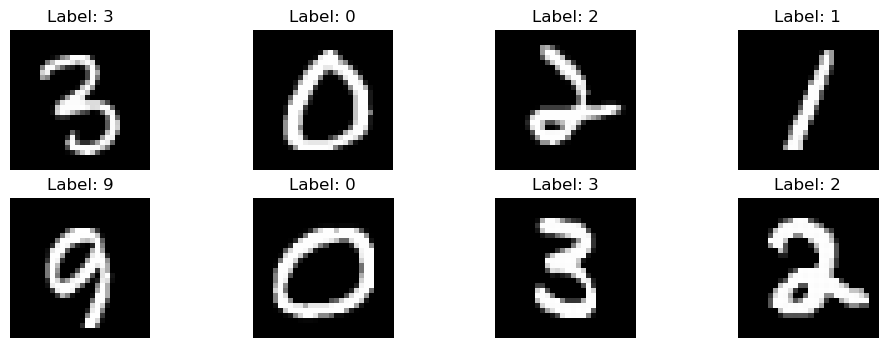

In [26]:
data_iter = iter(train_dataloader)
images, labels = next(data_iter)

print(f"images shape: {images.shape}") # [28, 28]

fig, axes = plt.subplots(2, 4, figsize=(12,4))
# axes = axes.flatten()

for i in range(8):
    ax = axes[i // 4, i % 4]
    ax.imshow(images[i].numpy().squeeze(), cmap="gray")
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis("off")
plt.show()

In [5]:
from typing import List

class MNISTANN(nn.Module):
    def __init__(self, input_size: int, hidden_layer_sizes: List[int], output_size: int):
        super().__init__()

        layer_sizes = [input_size] + hidden_layer_sizes + [output_size]

        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:
                layers.append(nn.ReLU())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28*28) 
        x = self.model(x)
        return x

In [6]:
# Optimizer and loss criteria
model = MNISTANN(input_size, hidden_layer_sizes, output_size)

optimizers = ["SGD", "Adam"]
selected_optimizer = "SGD"

# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
optimizer = getattr(optim, selected_optimizer)(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [7]:
# Training
def train_model(optimizer, loss_fn, train_dataloader):
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()

            output = model(images)
            loss = loss_fn(output, labels)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            if (i+1) % 1000 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs},Step: {i+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}')

        average_loss = epoch_loss / len(train_dataloader)
        accuracy = 100 * correct/ total

        train_losses.append(average_loss)
        train_accuracies.append(accuracy)
        print(f"Epoch: {epoch + 1} completed, Average Loss: {average_loss:.4f}")
            
    print("Training completed")
    return train_losses, train_accuracies
                  

Epoch: 1/4,Step: 1000/3750, Loss: 2.2499
Epoch: 1/4,Step: 2000/3750, Loss: 2.2537
Epoch: 1/4,Step: 3000/3750, Loss: 2.1023
Epoch: 1 completed, Average Loss: 2.2367
Epoch: 2/4,Step: 1000/3750, Loss: 1.7572
Epoch: 2/4,Step: 2000/3750, Loss: 1.3359
Epoch: 2/4,Step: 3000/3750, Loss: 0.7564
Epoch: 2 completed, Average Loss: 1.4563
Epoch: 3/4,Step: 1000/3750, Loss: 0.9415
Epoch: 3/4,Step: 2000/3750, Loss: 1.0750
Epoch: 3/4,Step: 3000/3750, Loss: 0.5538
Epoch: 3 completed, Average Loss: 0.6794
Epoch: 4/4,Step: 1000/3750, Loss: 1.1257
Epoch: 4/4,Step: 2000/3750, Loss: 0.4749
Epoch: 4/4,Step: 3000/3750, Loss: 0.3588
Epoch: 4 completed, Average Loss: 0.5049
Training completed


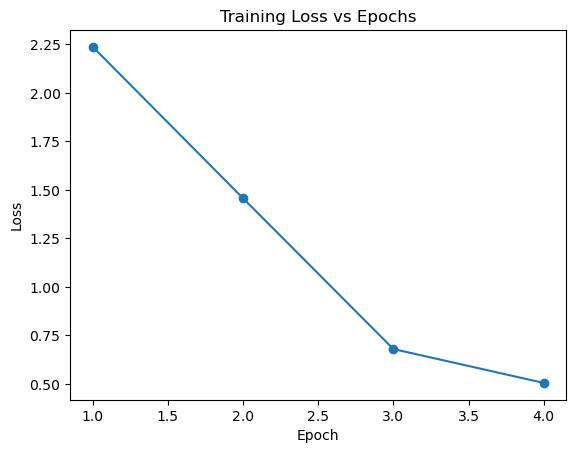

In [8]:
# Loss vs Epoch plot
losses, accuracies = train_model(optimizer, loss_fn, train_dataloader)

plt.plot(range(1, num_epochs+ 1), losses, marker="o")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.show()

In [39]:
def test_model(model, test_loader, criterion):
    model.eval()
    batch_losses = []
    batch_accuracies = []

    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            loss = criterion(outputs, labels)

            batch_losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            batch_correct = (predicted == labels).sum().item()
            batch_total = labels.size(0)
    
            batch_accuracy = 100 * batch_correct / batch_total
            batch_accuracies.append(batch_accuracy)

            correct += batch_correct
            total += batch_total
            
    avg_loss = sum(batch_losses) / len(batch_losses)
    avg_accurracy = 100 * correct / total

    return avg_loss, avg_accurracy, batch_losses, batch_accuracies
test_model(model, test_dataloader, loss_fn)

(0.12058800554950722,
 96.34,
 [0.008698100224137306,
  0.01198472362011671,
  0.02660394087433815,
  0.0022431935649365187,
  0.027741743251681328,
  0.00227354746311903,
  0.10101108253002167,
  0.3070361018180847,
  0.00725880591198802,
  0.35730382800102234,
  0.05593804270029068,
  0.0033393411431461573,
  0.010884473100304604,
  0.02386615052819252,
  0.017996907234191895,
  0.20439794659614563,
  0.13448788225650787,
  0.013676638714969158,
  0.07697509229183197,
  0.003683086484670639,
  0.2654242217540741,
  0.2359604686498642,
  0.11474359035491943,
  0.0553525909781456,
  0.022606324404478073,
  0.009410138241946697,
  0.17614372074604034,
  0.6270924806594849,
  0.19138219952583313,
  0.007375468034297228,
  0.26892685890197754,
  0.06708621233701706,
  0.005277114454656839,
  0.03415122628211975,
  0.024026278406381607,
  0.18255260586738586,
  0.19413480162620544,
  0.00867712777107954,
  0.33482351899147034,
  0.1525111347436905,
  0.06526630371809006,
  0.13067497313022

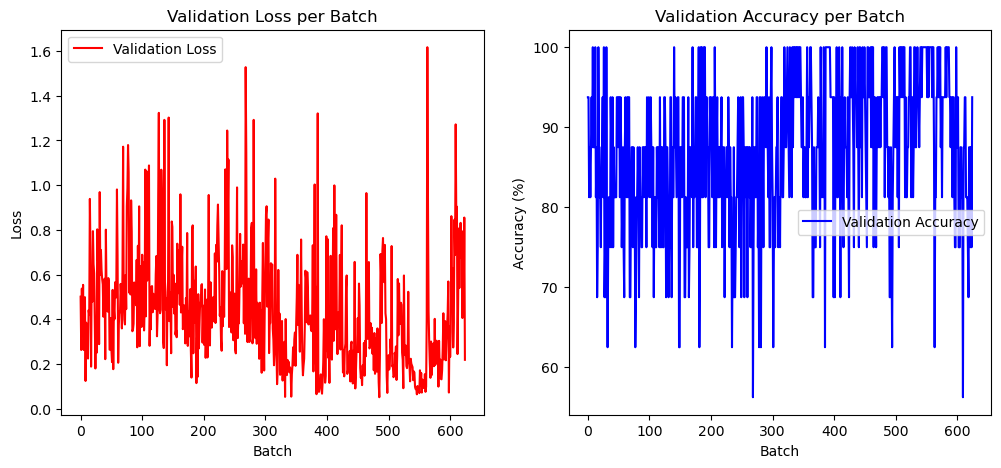

In [11]:
val_losses, val_accuracies = test_model(model, test_dataloader, loss_fn)

# Plot Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Validation Loss per Batch')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='blue')
plt.xlabel('Batch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy per Batch')
plt.legend()

plt.show()


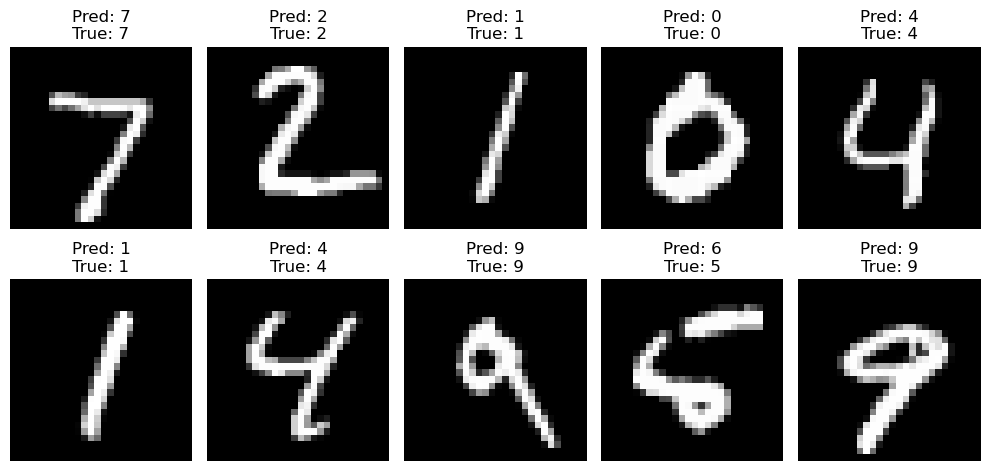

In [12]:
def visualize_test_data(model, test_loader, classes):
    model.eval()
    images, labels = next(iter(test_loader))

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  

    fig, axes = plt.subplots(2, 5, figsize=(10, 5)) 
    axes = axes.flatten()

    for i in range(10):
        img = images[i].squeeze()
        axes[i].imshow(img.cpu().numpy(), cmap='gray')
        axes[i].set_title(f'Pred: {classes[preds[i].item()]}\nTrue: {classes[labels[i].item()]}')
        axes[i].axis('off') 

    plt.tight_layout()
    plt.show()

classes = [str(i) for i in range(10)]

visualize_test_data(model, test_dataloader, classes)


In [ ]:
# K-Fold Cross-Validation
from torch.utils.data import Subset
kfold = KFold(n_splits=2, shuffle=True)
results = {
            'train_loss': [],
            'train_acc': [], 
            'val_loss': [], 
            'val_acc': []
            }

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f'Fold {fold + 1}')

    # Training and validation subsets
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    # Dataloader for Train and validation sets
    trainloader = DataLoader(train_subset, batch_size=64, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=64, shuffle=False)

    # Model, optimizer, loss function
    model = MNISTANN(input_size, hidden_layer_sizes, output_size)  
    optimizers = ["SGD", "Adam"]
    selected_optimizer = "Adam"

    # optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    optimizer = getattr(optim, selected_optimizer)(model.parameters(), lr=learning_rate)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Store epoch-wise loss and accuracy for each fold
    fold_train_loss = []
    fold_train_acc = []
    fold_val_loss = []
    fold_val_acc = []

    train_loss, train_acc = train_model(optimizer, loss_fn, trainloader)
    fold_train_loss.extend(train_loss)
    fold_train_acc.extend(train_acc)

    # Validate the model
    val_loss, val_acc, _, _ = test_model(model, valloader, loss_fn)
    fold_val_loss.append(val_loss)
    fold_val_acc.append(val_acc)

    # Update results
    results['train_loss'].append(fold_train_loss[-1])
    results['train_acc'].append(fold_train_acc[-1])
    results['val_loss'].append(fold_val_loss[-1])
    results['val_acc'].append(fold_val_acc[-1])

    # Loss/accuracy for the fold based on the last epoch's values
    print(f'Training Loss: {fold_train_loss[-1]:.4f}, Training Accuracy: {fold_train_acc[-1]:.2f}%')
    print(f'Validation Loss: {fold_val_loss[-1]:.2f}, Validation Accuracy: {fold_val_acc[-1]:.2f}%')

# Average results from all folds
avg_train_loss = sum(results['train_loss']) / len(results['train_loss'])
avg_train_acc = sum(results['train_acc']) / len(results['train_acc'])
avg_val_loss = sum(results['val_loss']) / len(results['val_loss'])
avg_val_acc = sum(results['val_acc']) / len(results['val_acc'])

print(f'Average Training Loss: {avg_train_loss:.4f}, Average Training Accuracy: {avg_train_acc:.2f}%')
print(f'Average Validation Loss: {avg_val_loss:.4f}, Average Validation Accuracy: {avg_val_acc:.2f}%')


Fold 1
Epoch: 1 completed, Average Loss: 0.5939
Epoch: 2 completed, Average Loss: 0.2880
Epoch: 3 completed, Average Loss: 0.2162
Epoch: 4 completed, Average Loss: 0.1762
Epoch: 5 completed, Average Loss: 0.1495
Epoch: 6 completed, Average Loss: 0.1275
Epoch: 7 completed, Average Loss: 0.1119
Epoch: 8 completed, Average Loss: 0.0998
Epoch: 9 completed, Average Loss: 0.0905
Epoch: 10 completed, Average Loss: 0.0794
Training completed
[96.03666666666666]
[0.1369341535867055]
Training Loss: 0.0794, Training Accuracy: 97.48%
Validation Loss: 0.14, Validation Accuracy: 96.04%
Fold 2
Epoch: 1 completed, Average Loss: 0.6074
Epoch: 2 completed, Average Loss: 0.2720
Epoch: 3 completed, Average Loss: 0.2022
Epoch: 4 completed, Average Loss: 0.1669
Epoch: 5 completed, Average Loss: 0.1407
Epoch: 6 completed, Average Loss: 0.1207
Epoch: 7 completed, Average Loss: 0.1106
Epoch: 8 completed, Average Loss: 0.0943
Epoch: 9 completed, Average Loss: 0.0809
Epoch: 10 completed, Average Loss: 0.0791
Trai

In [19]:
print(results["train_loss"]) # [0.1847568836285552, 0.15866782538481614]

print(results["val_loss"]) # [0.1999819129705429, 0.3565561771392822]

[0.17922768484491275, 0.1776323648316583]
[0.1059601679444313, 0.061561282724142075]


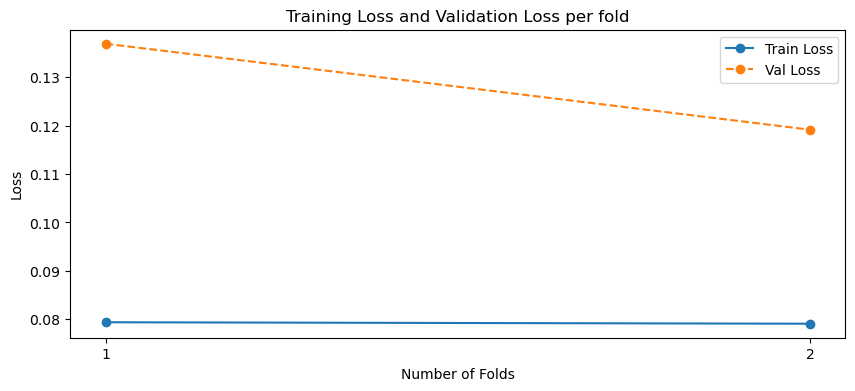

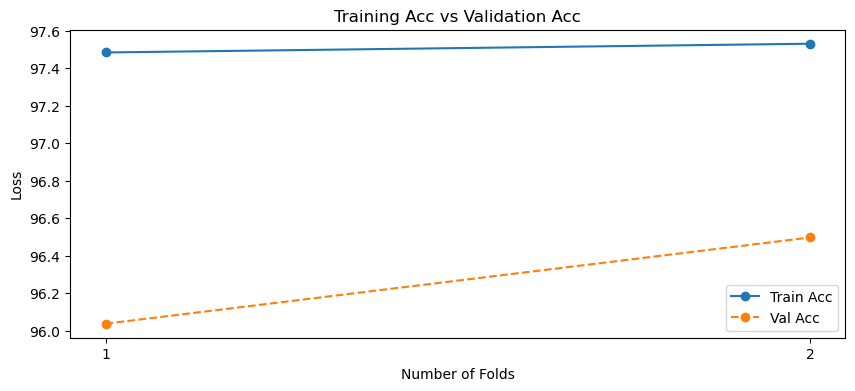

In [ ]:
import matplotlib.pyplot as plt

# Training loss vs. validation loss for each fold
plt.figure(figsize=(10, 4))
folds = range(1, len(results['train_loss']) + 1)

plt.plot(folds, results["train_loss"], label=f'Train Loss', marker="o")
plt.plot(folds, results["val_loss"], label=f'Val Loss', linestyle='dashed',  marker="o")

plt.xlabel('Number of Folds')
plt.ylabel('Loss')
plt.title('Training Loss and Validation Loss per fold')
plt.xticks(folds)
plt.legend()
plt.show()


plt.figure(figsize=(10, 4))
# folds = range(len(results['train_loss']))
plt.plot(folds, results["train_acc"], label=f'Train Acc', marker="o")
plt.plot(folds, results["val_acc"], label=f'Val Acc', linestyle='dashed',  marker="o")

plt.xlabel('Number of Folds')
plt.ylabel('Loss')
plt.title('Training Acc vs Validation Acc')
plt.xticks(folds)
plt.legend()
plt.show()



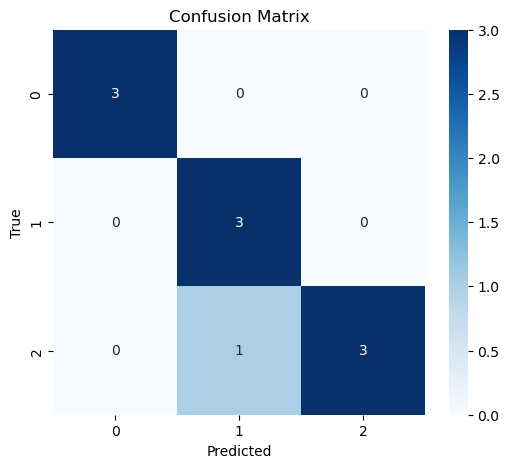

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = torch.tensor([0, 1, 2, 2, 0, 1, 2, 1, 0, 2]) 
y_pred = torch.tensor([0, 1, 2, 2, 0, 1, 1, 1, 0, 2])  

# Confusion matrix
cm = confusion_matrix(y_true.numpy(), y_pred.numpy())

# Heatmap plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
